#### Example of text classification with word2vec embeddings generated from the target corpus (Consumer Finance Complaints dataset).

Reference pages:
- https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
- https://sturzamihai.com/how-to-use-pre-trained-word-vectors-with-keras/
- https://towardsdatascience.com/nlp-for-beginners-cleaning-preprocessing-text-data-ae8e306bef0f
- https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/ipynb_with_output/Document%20classification%20with%20word%20embeddings%20tutorial%20-%20with%20output.ipynb

Dataset link: https://catalog.data.gov/dataset/consumer-complaint-database

Loading raw data.

In [1]:
import pandas as pd
df = pd.read_csv('complaints.csv')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2020-02-11,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,NaN,NaN,First Data Corporation,WA,98109,NaN,NaN,Web,2020-02-11,In progress,Yes,NaN,3528370
1,2020-01-27,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,"EQUIFAX, INC.",GA,30238,NaN,NaN,Web,2020-01-27,In progress,Yes,NaN,3509918
2,2020-02-02,Debt collection,Medical debt,Written notification about debt,Didn't receive notice of right to dispute,NaN,NaN,"Commonwealth Financial Systems, Inc.",CA,95330,Servicemember,NaN,Web,2020-02-02,Closed with explanation,Yes,NaN,3517453
3,2020-02-11,Mortgage,FHA mortgage,Trouble during payment process,NaN,NaN,NaN,"FLAGSTAR BANK, FSB",NY,12182,NaN,NaN,Referral,2020-02-11,In progress,Yes,NaN,3528676
4,2020-02-06,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,NaN,NaN,"MONEY SOURCE, THE",MD,207XX,NaN,NaN,Web,2020-02-06,Closed with explanation,Yes,NaN,3522478


The desired columns are ``Product`` (class labels) and ``Consumer complaint narrative`` (text documents).

In [2]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Product', 'Consumer_complaint_narrative']
df['category_id'] = df['Product'].factorize()[0]
print(df.isnull().sum())
df.head()

Product                         0
Consumer_complaint_narrative    0
category_id                     0
dtype: int64


,Product,Consumer_complaint_narrative,category_id
10,"Credit reporting, credit repair services, or o...",I HAD FILED WITH CFPB ON XX/XX/XXXX19 TO HAVE ...,0
35,"Credit reporting, credit repair services, or o...","XXXX XXXX XXXX, which went bankrupt a differen...",0
36,"Credit reporting, credit repair services, or o...",I kept receiving calls from a company stating ...,0
37,Debt collection,This is a reverse credit card complaint. \n\nM...,1
42,"Credit reporting, credit repair services, or o...",I was unable to request a security freeze with...,0


Let's check the classes distribution.

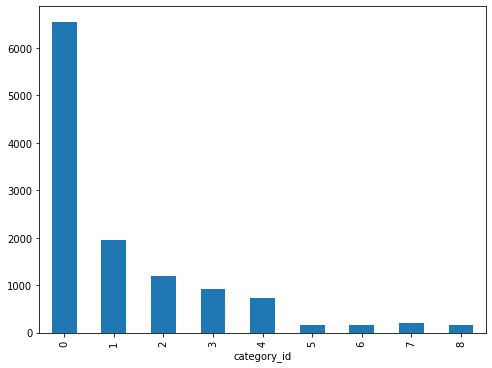

category_id
0    6552
1    1952
2    1200
3     921
4     719
5     164
6     151
7     191
8     163
Name: Consumer_complaint_narrative, dtype: int64

In [3]:
%matplotlib inline

from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
count = df.groupby('category_id').Consumer_complaint_narrative.count()
count.plot.bar(ylim=0)
plt.show()
count

The dataset is unbalanced. Let's limit our analysis to the most frequent categories and create a balanced dataset.

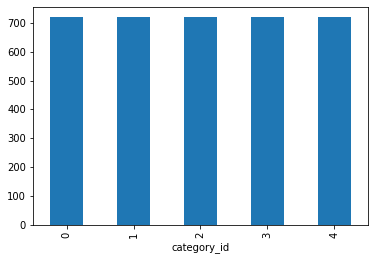

In [4]:
df2 = df.drop(df[df['category_id'].isin([5, 6, 7, 8])].index).reset_index(drop=True)
df2.head()

balanced_df = df2.groupby('category_id')
balanced_df = balanced_df.apply(lambda x: x.sample(balanced_df.size().min())).reset_index(drop=True)

count = balanced_df.groupby('category_id').Consumer_complaint_narrative.count()
count.plot.bar(ylim=0)
plt.show()

Saving our balanced dataset.

In [7]:
balanced_df.to_csv('complaints-balanced.csv')

Text preprocessing

In [5]:
%%time
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# TODO remove xxx words

text = balanced_df.Consumer_complaint_narrative
# removing numbers
text = text.apply(lambda x: re.sub(r'\d+', '', x))

# tokenizing, removing punctuation and converting to lower case
tokenizer = RegexpTokenizer(r'\w+')
text = text.apply(lambda x: tokenizer.tokenize(x.lower()))

# stop words removal
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words
text = text.apply(lambda x: remove_stopwords(x))

text.head()

CPU times: user 1min 42s, sys: 9.21 s, total: 1min 51s
Wall time: 1min 51s


0    [collection, account, amount, appeared, credit...
1    [credit, report, xxxx, xxxx, xxxx, pull, credi...
2    [writing, dispute, accounts, fraudulently, ope...
3    [xx, xx, xxxx, husband, credit, reports, pulle...
4    [enlisting, consumer, rights, compel, enacting...
Name: Consumer_complaint_narrative, dtype: object

Creating train and test sets, with balanced frequency of classes.

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
for train_index, test_index in sss.split(text, balanced_df['category_id']):
    train_set = text.loc[train_index]
    train_labels = balanced_df['category_id'].loc[train_index]
    test_set = text.loc[test_index]
    test_labels = balanced_df['category_id'].loc[test_index]

Creating word embeddings.

Word2vec parameters:
- `size=n` - The dimension that the Word2Vec vectors will have.
- `min_count=n` - Include the word in our vocabulary after n encounters.
- `iter=n` - In how many epochs should the Word2Vec model learn the semantic correlations.

In [23]:
%%time
import gensim

word_model = gensim.models.Word2Vec(train_set, size=300, min_count=2, iter=10)

CPU times: user 13.6 s, sys: 97.4 ms, total: 13.7 s
Wall time: 6.13 s


In [24]:
word_model.wv.most_similar(positive='quality')

[('devastating', 0.96532142162323),
 ('prevented', 0.9635800123214722),
 ('fer', 0.961974024772644),
 ('wrongfully', 0.9612576961517334),
 ('granting', 0.9593113660812378),
 ('unsuspecting', 0.9587297439575195),
 ('references', 0.9586407542228699),
 ('subprime', 0.9585227966308594),
 ('sophisticated', 0.9579693078994751),
 ('alt', 0.9579389095306396)]

Each document must be converted to a vector. So, we'll use the mean vector of its words.

In [25]:
import numpy as np

def word_averaging(model, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in model.wv.vocab:
            mean.append(model.wv.vectors_norm[model.wv.vocab[word].index])
            all_words.add(model.wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(model.layer1_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(model, text_list):
    return np.vstack([word_averaging(model, review) for review in text_list ])

In [26]:
%%time
X_train_word_average = word_averaging_list(word_model, train_set)
X_test_word_average = word_averaging_list(word_model, test_set)

CPU times: user 1.29 s, sys: 130 µs, total: 1.29 s
Wall time: 1.29 s


Let's train and evaluate some classifiers.

In [38]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.neural_network import MLPClassifier

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LogisticRegression(solver='lbfgs', multi_class='auto', random_state=0),
    svm.LinearSVC(random_state=0),
    MLPClassifier(max_iter=1000, random_state=0)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train_word_average, train_labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

CPU times: user 2min 28s, sys: 1.64 s, total: 2min 30s
Wall time: 1min 22s


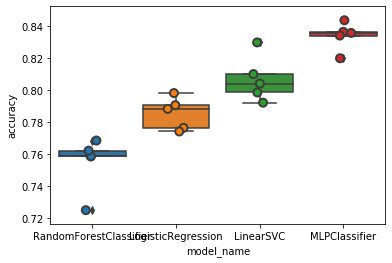

In [39]:
%matplotlib inline
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [40]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.806794
LogisticRegression        0.785359
MLPClassifier             0.833867
RandomForestClassifier    0.754394
Name: accuracy, dtype: float64

Best model evaluation

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix

my_tags = balanced_df.category_id.unique()
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

accuracy 0.8220574606116775
confusion matrix
 [[161  29  17   2   7]
 [ 22 169  12   8   5]
 [  9   8 180   2  17]
 [  2   2   7 201   4]
 [  3   3  27   6 176]]
(row=expected, col=predicted)
CPU times: user 53.5 s, sys: 1.04 s, total: 54.6 s
Wall time: 27.3 s


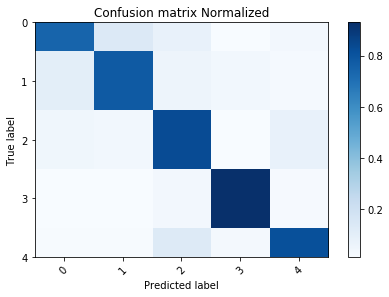

In [51]:
%%time
model = models[3]
model.fit(X_train_word_average, train_labels)
predicted = model.predict(X_test_word_average)
evaluate_prediction(predicted, test_labels)

Exploring misclassifications

In [ ]:
# TODO